**KMNIST IMAGE CLASSIFICATION USING CNN**

In this project, I have trained a Convolutional Neural Network (CNN) to classify handwritten characters from the Kuzushiji-MNIST (KMNIST) dataset.

Firstly, I installed necessary libraries to build and train my model.

In [1]:
!pip install torch
!pip install torchvision
!pip install matplotlib

Then, I imported all the necessary PyTorch modules for my project. Dataset, DataLoader, transforms, nn all are necessary for successful creation and training of my CNN in this project.

In [2]:
# Import PyTorch modules needed
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.datasets as dsets
torch.manual_seed(0)

Here, I have checked if a CUDA-capable GPU is available using torch.cuda.is_available(). If it is, I set the device to use the first GPU (cuda:0) for faster model training and computation.

In [3]:
torch.cuda.is_available()
device = torch.device('cuda:0')

In [4]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

In [5]:
def show_data(d_s):
    image = d_s[0]
    plt.imshow(image.numpy().reshape(16,16), cmap='gray')
    plt.title('y = ' + str(d_s[1]))
    plt.show()

At this step, I set up some of image transformations to resize images to 16x16 pixels and convert them into tensor format. This ensures that the images are properly formatted for input into the neural network.

In [6]:
composed = transforms.Compose([transforms.Resize((16,16)), transforms.ToTensor()])

At this step, I load the training and validation datasets (KMNIST)

In [7]:
#Training Data Set
dataset_train = dsets.KMNIST(
    root = './data',
    train = True,
    download = True,
    transform = composed
)
#Validation Data Set
dataset_val = dsets.KMNIST(
    root = './data',
    train = False,
    download = False,
    transform = composed
)

Viewing some of the samples in validation dataset.

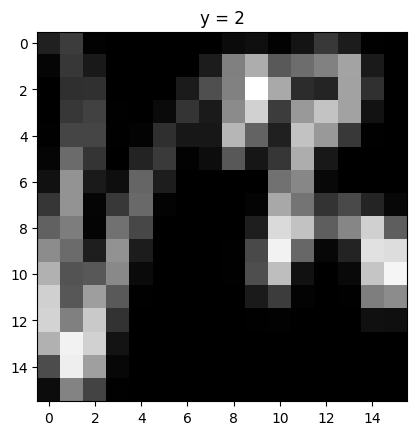

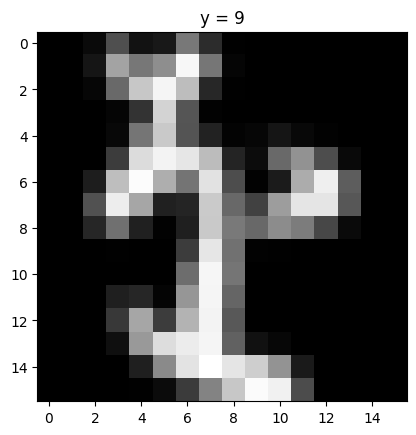

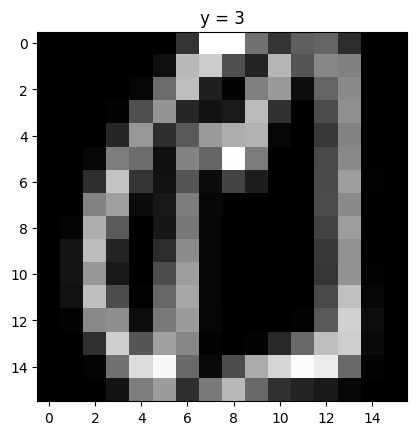

In [8]:
for n, data_sample in enumerate(dataset_val):
  show_data(data_sample)
  plt.show()
  if n==2:
    break

Here, complete model architecture is defined. I have created a CNN for this task. I have also used batch normalization to practically see its effects on my model. Initially, I trained a model without using batch normalization, and there were considerable differences in the results as compared to this current model.

In [9]:
class CNN(nn.Module):
    def __init__(self, out_1=16, out_2=32, out_3=64, number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(out_3)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_3 * 2 * 2, number_of_classes)

    def conv_layers(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Here, I have loaded the datasets in loaders by keeping the batch size of 100 for smooth processing.

In [10]:
train_loader = DataLoader(dataset=dataset_train, batch_size=100)
validation_loader = DataLoader(dataset=dataset_val, batch_size=100)

In [11]:
model = CNN(out_1=16, out_2=32, out_3=64, number_of_classes=10)
model.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
)

Here, I have created criterion (to determine the loss of my model) and optimizer (to update parameters accordingly). I am using Cross Entropy Loss and Stochastic Gradient Descent (SGD) as loss function and optimizer respectively.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In this second last stage, I have trained the model on training set and also keeping the record of cost. Moreover, the model is also being evaluated on validation dataset and accuracy is being calculated.

The total number of epochs is 25.

At the end of each iteration, loss and accuracy is being printed to see model's progress.

In [13]:
cost_l = []
accuracy_l = []
N_test = len(dataset_val)
n_epochs = 25
for epoch in range(n_epochs):
    cost = 0
    model.train()
    for x,y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      prediction = model(x)
      loss = criterion(prediction, y)
      loss.backward()
      optimizer.step()
      cost += loss.item()
    correct = 0
    model.eval()
    for x_test, y_test in validation_loader:
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      prediction = model(x_test)
      _, yhat = torch.max(prediction.data, 1)
      correct += (yhat == y_test).sum().item()
    accuracy = correct/N_test
    cost = cost/len(train_loader)
    cost_l.append(cost)
    accuracy_l.append(accuracy)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {cost:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/25, Loss: 0.5824, Accuracy: 0.8094
Epoch 2/25, Loss: 0.2175, Accuracy: 0.8587
Epoch 3/25, Loss: 0.1524, Accuracy: 0.8850
Epoch 4/25, Loss: 0.1196, Accuracy: 0.8984
Epoch 5/25, Loss: 0.0992, Accuracy: 0.9091
Epoch 6/25, Loss: 0.0848, Accuracy: 0.9151
Epoch 7/25, Loss: 0.0741, Accuracy: 0.9222
Epoch 8/25, Loss: 0.0656, Accuracy: 0.9249
Epoch 9/25, Loss: 0.0585, Accuracy: 0.9280
Epoch 10/25, Loss: 0.0526, Accuracy: 0.9308
Epoch 11/25, Loss: 0.0474, Accuracy: 0.9339
Epoch 12/25, Loss: 0.0430, Accuracy: 0.9350
Epoch 13/25, Loss: 0.0391, Accuracy: 0.9356
Epoch 14/25, Loss: 0.0356, Accuracy: 0.9356
Epoch 15/25, Loss: 0.0326, Accuracy: 0.9376
Epoch 16/25, Loss: 0.0298, Accuracy: 0.9376
Epoch 17/25, Loss: 0.0274, Accuracy: 0.9383
Epoch 18/25, Loss: 0.0252, Accuracy: 0.9384
Epoch 19/25, Loss: 0.0233, Accuracy: 0.9394
Epoch 20/25, Loss: 0.0214, Accuracy: 0.9397
Epoch 21/25, Loss: 0.0198, Accuracy: 0.9401
Epoch 22/25, Loss: 0.0184, Accuracy: 0.9403
Epoch 23/25, Loss: 0.0171, Accuracy: 0.94

At this final stage, I have plotted cost (in red) and accuracy (in blue) to better visualize the results.

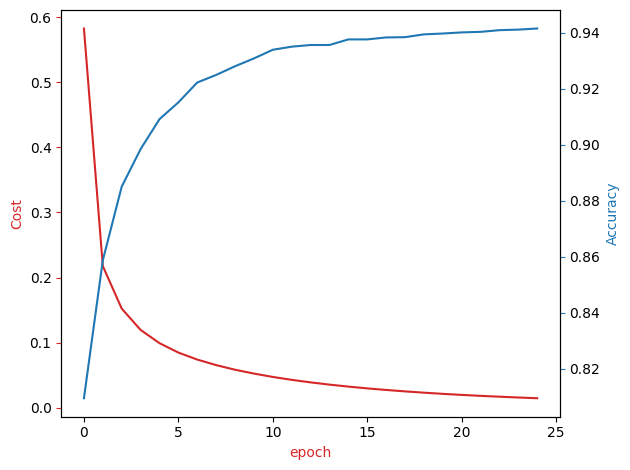

In [15]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_l, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_l, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()